## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [ ]:
!pip install --upgrade keras-cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetV2L
import keras_cv
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 36.6 MB/s eta 0:00:00


## ⏳ Load the Data

In [3]:
# Load training data, images, and labels from the 'training_set.npz' file.
data = np.load('training_set.npz')
images = data['images']
labels = data['labels']

## 🔍 Inspect the Data

In [4]:
# Show shapes of data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Show data types
print("Images data type:", images.dtype)
print("Labels data type:", labels.dtype)

Images shape: (13759, 96, 96, 3)
Labels shape: (13759, 1)
Images data type: uint8
Labels data type: uint8


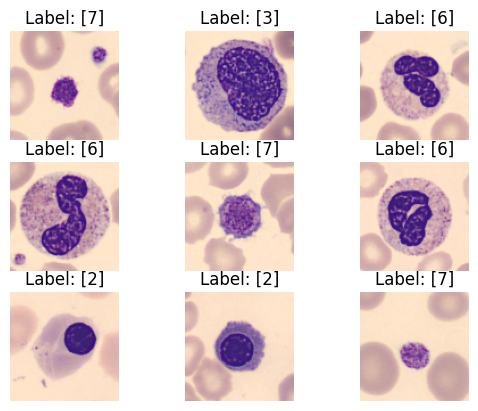

In [5]:
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

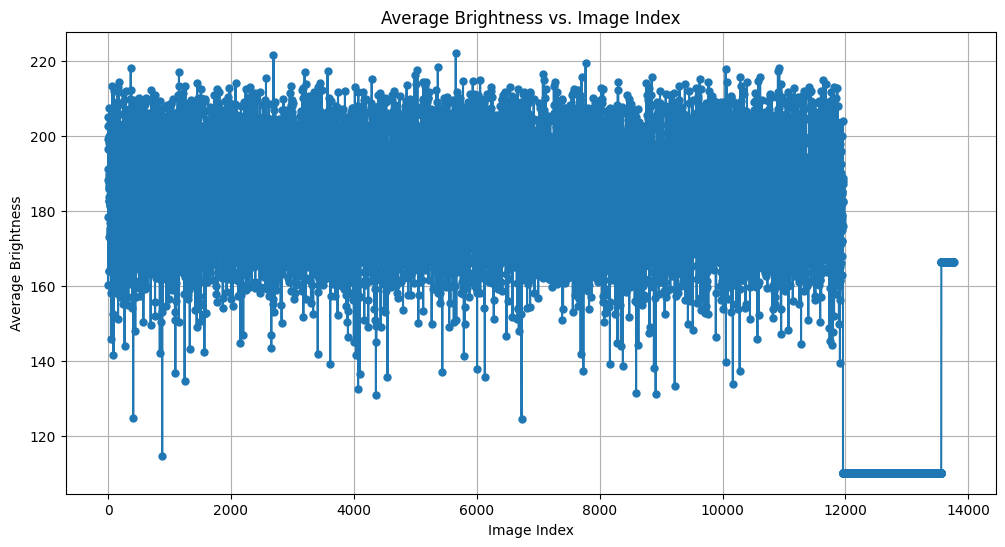

In [6]:
# Graph showing avg brightness from each image
avg_brightness_values = [np.mean(image) for image in images]

plt.figure(figsize=(12, 6))
plt.plot(range(len(images)), avg_brightness_values, marker='o', linestyle='-', markersize=5)
plt.xlabel('Image Index')
plt.ylabel('Average Brightness')
plt.title('Average Brightness vs. Image Index')
plt.grid(True)
plt.show()

In [7]:
# Keep images with indices from 0 to 11999
images = images[:11959]
labels = labels[:11959]

# Show shapes of data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)


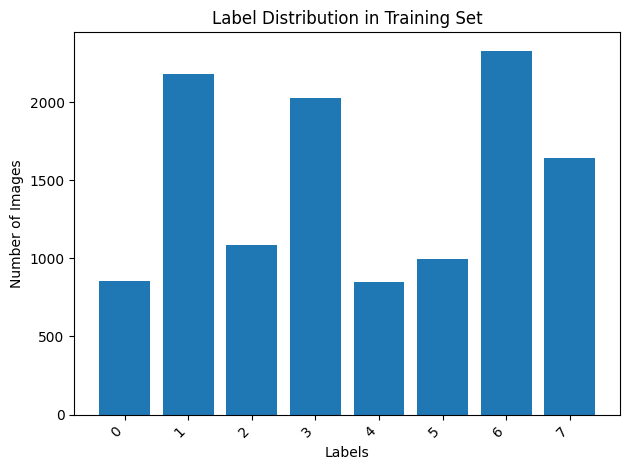

In [8]:
# Get unique labels and their counts (this part is the same as before)
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create the bar chart
plt.bar(unique_labels, label_counts)

# Customize the chart
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Label Distribution in Training Set")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the chart
plt.tight_layout()  # Adjust spacing
plt.show()

## ⚡Feature Extractor

In [9]:
# Split into training and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

# Split into val and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert labels to categorical format
y_train = tfk.utils.to_categorical(y_train, num_classes=len(np.unique(labels)))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(np.unique(labels)))

del images, labels, X_temp, y_temp

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10763, 96, 96, 3), y_train shape: (10763, 8)
X_val shape: (598, 96, 96, 3), y_val shape: (598, 8)
X_test shape: (598, 96, 96, 3), y_test shape: (598, 1)


In [10]:
# Convert numpy arrays to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset = train_dataset.batch(64)
val_dataset = val_dataset.batch(64)

del X_train, X_val, y_train, y_val

In [11]:
# Apply online randaugmentation
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    seed=42
)

def apply_randaugment(image, label):
    image = rand_augment(image)
    return image, label

train_dataset = train_dataset.map(apply_randaugment, num_parallel_calls=tf.data.AUTOTUNE)

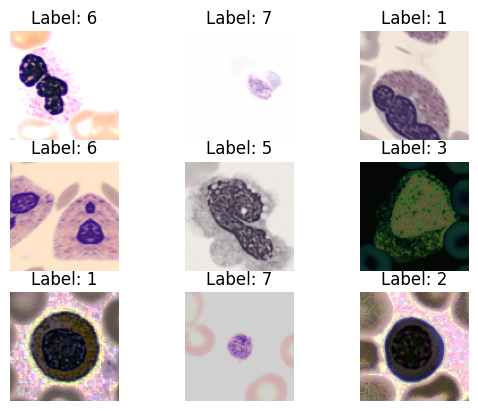

In [12]:
# Take a few batches from the dataset
for images, labels in train_dataset.take(1):
    # Iterate through images in the batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis("off")

plt.show()

In [13]:
# Initialize effnet with pretrained weights for transfer learning
effnet = tfk.applications.EfficientNetV2L(
    input_shape=(512, 512, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze all layers in effnet for feature extraction
effnet.trainable = False

# Define input layer and data augmentation
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Resizing before feeding to effnet
x = tfkl.Resizing(512, 512)(inputs)

# Pass augmented inputs through the efficientnet feature extractor
x = effnet(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout1')(x)

# Intermediate dense layer
x = tfkl.Dense(512, activation='relu', name='intermediate_dense')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout2')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(8, activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Create an adamW optimizer with the cyclical learning rate
optimizer = tfk.optimizers.AdamW(learning_rate=1e-4)

# Create categorical focal cross-entropy loss
loss = keras_cv.losses.FocalLoss()

# Compile the model
tl_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
# ReduceLROnPlateau callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# EarlyStopping callback
es_callback = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Train the model
tl_history = tl_model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[lr_callback, es_callback]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'weights_tl.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 250s 845ms/step - accuracy: 0.3162 - loss: 0.1684 - val_accuracy: 0.6639 - val_loss: 0.1338 - learning_rate: 1.0000e-04
Epoch 2/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 295ms/step - accuracy: 0.5397 - loss: 0.1415 - val_accuracy: 0.7241 - val_loss: 0.1201 - learning_rate: 1.0000e-04
Epoch 3/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 295ms/step - accuracy: 0.6112 - loss: 0.1325 - val_accuracy: 0.7475 - val_loss: 0.1113 - learning_rate: 1.0000e-04
Epoch 4/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 296ms/step - accuracy: 0.6393 - loss: 0.1257 - val_accuracy: 0.7642 - val_loss: 0.1068 - learning_rate: 1.0000e-04
Epoch 5/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 295ms/step - accuracy: 0.6604 - loss: 0.1223 - val_accuracy: 0.8043 - val_loss: 0.0996 - learning_rate: 1.0000e-04
Epoch 6/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 295ms/step - accuracy: 0.6820 - loss: 0.1178 - val_accuracy: 0.8261 - val_loss: 0.0922 - learning_rate: 1.0000e-04
Epoch 7/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 2

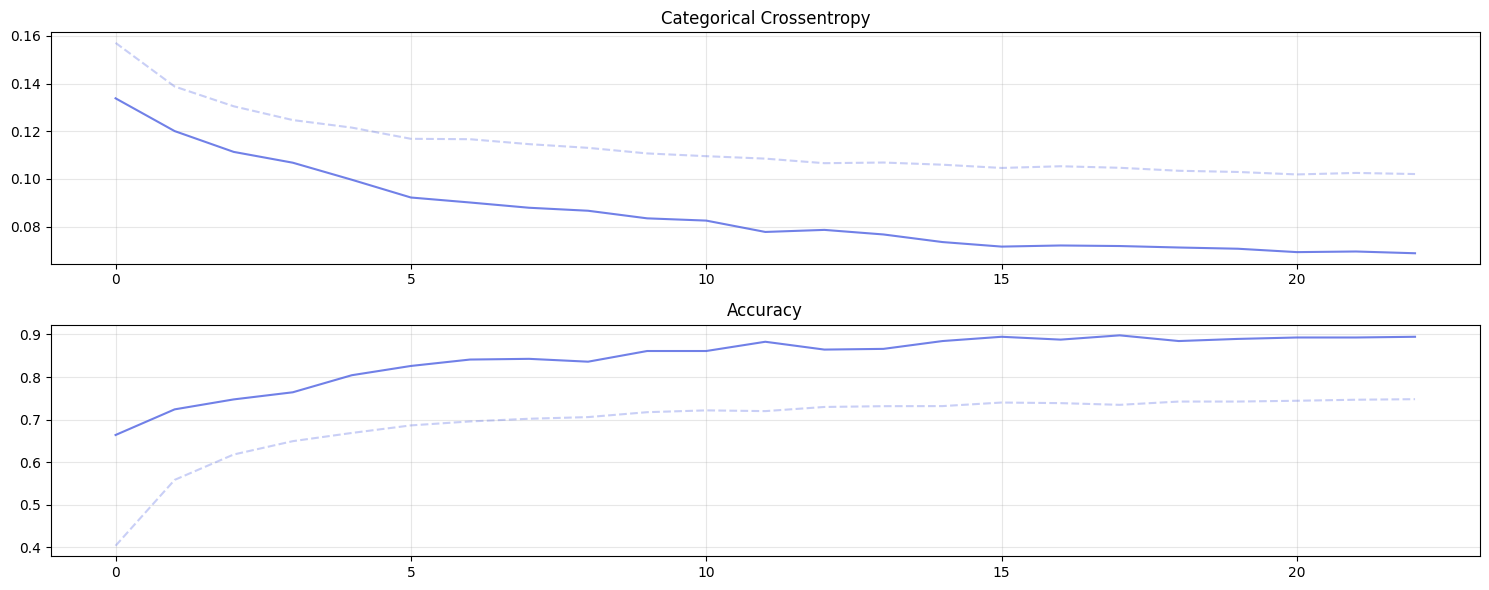

In [15]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot loss for transfer learning models
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy')
ax1.grid(alpha=0.3)

# Plot accuracy for transfer learning models
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], alpha=0.8, color='#4D61E2')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent label overlap and display the plots
plt.tight_layout()
plt.show()

## 🎧 Fine Tuning

In [16]:
# Load the transfer learning model
ft_model = tfk.models.load_model('weights_tl.keras')

# Cosine decay restarts lr scheduler
learning_rate_schedule = tfk.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=156 * 5,
    alpha=0.001
)

# Create an optimizer with the cyclical learning rate
optimizer = tfk.optimizers.AdamW(learning_rate_schedule)

# Create categorical focal cross-entropy loss
loss = keras_cv.losses.FocalLoss()

# Compile the fine-tuning model with a lower learning rate
ft_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Freeze base, with exception of the last layers
set_trainable = False
for layer in ft_model.layers[2].layers:
    if layer.name == 'block5a_expand_conv':
        set_trainable = True
    if set_trainable:
        # Ensure BatchNorm layers remain frozen
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
    else:
        layer.trainable = False

# Print trainable status of each layer, including VGG19 sublayers
for i, layer in enumerate(ft_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

    # Check if the layer is the effnet model
    if isinstance(layer, tfk.Model) and layer.name == ft_model.layers[2].name:
        print("  EffNet Sublayers:")
        for sublayer in layer.layers:
            print(f"    {sublayer.name}, Trainable: {sublayer.trainable}")

Layer 0: input_layer, Trainable: True
Layer 1: resizing, Trainable: True
Layer 2: efficientnetv2-l, Trainable: False
  EffNet Sublayers:
    input_layer, Trainable: False
    rescaling, Trainable: False
    stem_conv, Trainable: False
    stem_bn, Trainable: False
    stem_activation, Trainable: False
    block1a_project_conv, Trainable: False
    block1a_project_bn, Trainable: False
    block1a_project_activation, Trainable: False
    block1a_add, Trainable: False
    block1b_project_conv, Trainable: False
    block1b_project_bn, Trainable: False
    block1b_project_activation, Trainable: False
    block1b_drop, Trainable: False
    block1b_add, Trainable: False
    block1c_project_conv, Trainable: False
    block1c_project_bn, Trainable: False
    block1c_project_activation, Trainable: False
    block1c_drop, Trainable: False
    block1c_add, Trainable: False
    block1d_project_conv, Trainable: False
    block1d_project_bn, Trainable: False
    block1d_project_activation, Trainable:

In [17]:
# EarlyStopping callback
es_callback = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Train the model
ft_history = ft_model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[es_callback]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.5979 - loss: 0.1487 - val_accuracy: 0.9615 - val_loss: 0.0266
Epoch 2/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 107s 619ms/step - accuracy: 0.9067 - loss: 0.0476 - val_accuracy: 0.9716 - val_loss: 0.0222
Epoch 3/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 107s 619ms/step - accuracy: 0.9350 - loss: 0.0329 - val_accuracy: 0.9799 - val_loss: 0.0131
Epoch 4/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 107s 620ms/step - accuracy: 0.9531 - loss: 0.0249 - val_accuracy: 0.9900 - val_loss: 0.0072
Epoch 5/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 106s 617ms/step - accuracy: 0.9565 - loss: 0.0213 - val_accuracy: 0.9615 - val_loss: 0.0257
Epoch 6/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 106s 616ms/step - accuracy: 0.9273 - loss: 0.0364 - val_accuracy: 0.9615 - val_loss: 0.0173
Epoch 7/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 106s 617ms/step - accuracy: 0.9369 - loss: 0.0316 - val_accuracy: 0.9716 - val_loss: 0.0153
Epoch 8/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 106s 617ms/step - accuracy: 0.9485 - lo

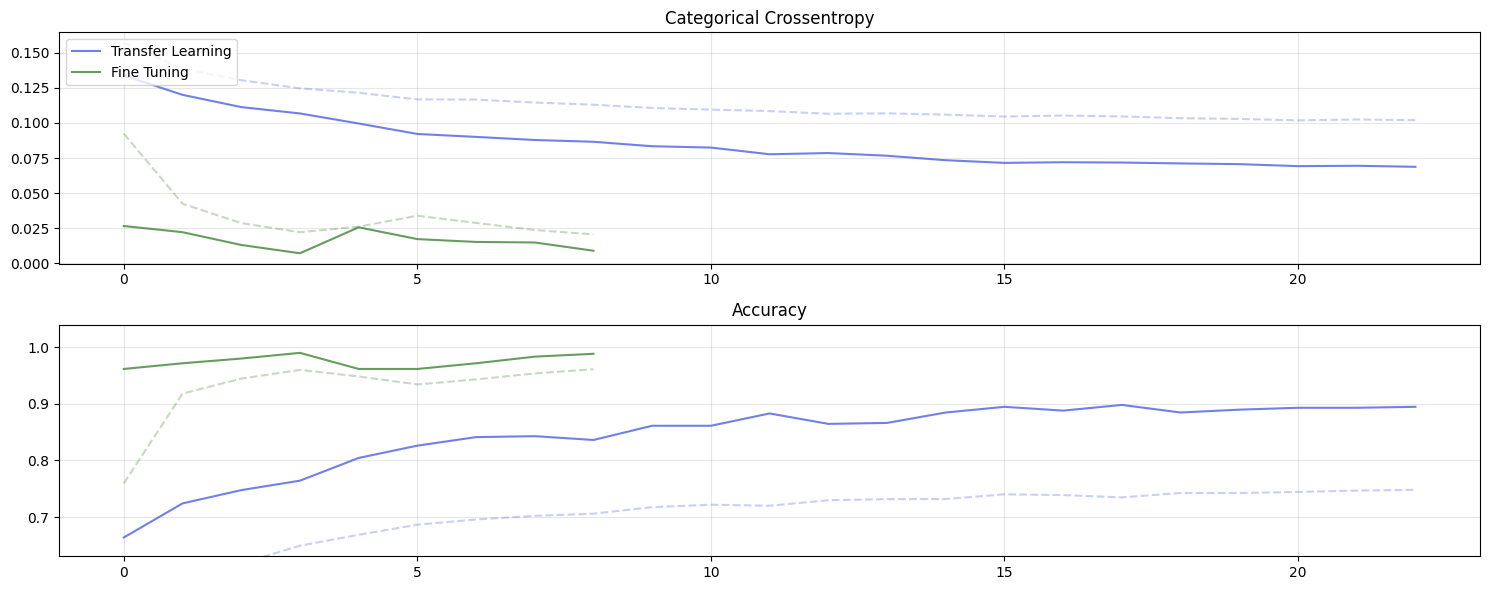

In [18]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

## ⚓ Testing

19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step
Accuracy: 0.9833

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      1.00      1.00       109
           2       1.00      0.98      0.99        54
           3       0.95      0.99      0.97       102
           4       0.96      1.00      0.98        43
           5       0.96      0.96      0.96        50
           6       1.00      0.95      0.97       116
           7       1.00      1.00      1.00        82

    accuracy                           0.98       598
   macro avg       0.98      0.98      0.98       598
weighted avg       0.98      0.98      0.98       598



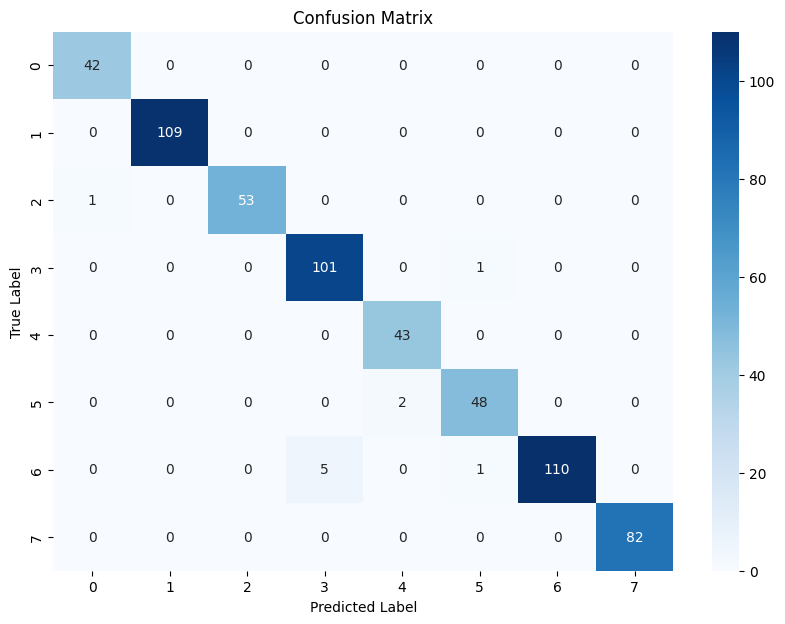

In [19]:
# Load model
model = tfk.models.load_model('weights.keras')

# Make predictions
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(conf_matrix.shape[1]),
            yticklabels=range(conf_matrix.shape[1]))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

del model